# Фаза 2. Неделя 11
## Рекомендательные системы
### Базовый нейросетевой подход

In [1]:
from google.colab import files
uploaded = files.upload()

Saving ml-100k.zip to ml-100k.zip


In [2]:
import zipfile
import io

file_name = 'ml-100k.zip'

with zipfile.ZipFile(io.BytesIO(uploaded[file_name]), 'r') as zip_ref:
    zip_ref.extractall('/content')

In [3]:
%load_ext autoreload
%autoreload 2

In [ ]:
!pip install torchutils

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from tqdm import tqdm
import torchutils as tu
torch.manual_seed(666)

# эта строка закомментирована, потому что эти
# функции вам предстоит реализовать в сегодняшнем задании
#from aux.recommend import *

In [6]:
device = 'cpu' #'cuda' if torch.cuda.is_available() else 'cpu'

In [7]:
col_names = ['user_id','item_id','rating','timestamp']
train_df = pd.read_csv('/content/ml-100k/u1.base', sep='\t', header=None, names=col_names)
valid_df = pd.read_csv('/content/ml-100k/u1.test', sep='\t', header=None, names=col_names)

In [8]:
movie_id = pd.read_csv('/content/ml-100k/u.item', sep='|', encoding="iso-8859-1", header=None).iloc[:, 0: 2]
movie_id.columns = ['id', 'title']
movie_id['id'] = movie_id['id']
id_to_movie = dict(zip(movie_id['id'], movie_id['title']))

In [9]:
train_df[['user_id', 'item_id']] = train_df[['user_id', 'item_id']]
valid_df[['user_id', 'item_id']] = valid_df[['user_id', 'item_id']]

In [10]:
train_df

,user_id,item_id,rating,timestamp
0,1,1,5,874965758
1,1,2,3,876893171
2,1,3,4,878542960
3,1,4,3,876893119
4,1,5,3,889751712
...,...,...,...,...
79995,943,1067,2,875501756
79996,943,1074,4,888640250
79997,943,1188,3,888640250
79998,943,1228,3,888640275


In [11]:
train_df['user_id'].nunique()

943

In [12]:
# Эти данные нужны для эмбеддинг слоев
UNIQUE_USERS = train_df['user_id'].nunique() + 1
UNIQUE_MOVIES = len(id_to_movie.items()) + 1
print(f'Unique users: {UNIQUE_USERS}, unique movies: {UNIQUE_MOVIES}')

Unique users: 944, unique movies: 1683


In [13]:
display(train_df)
display(valid_df)

,user_id,item_id,rating,timestamp
0,1,1,5,874965758
1,1,2,3,876893171
2,1,3,4,878542960
3,1,4,3,876893119
4,1,5,3,889751712
...,...,...,...,...
79995,943,1067,2,875501756
79996,943,1074,4,888640250
79997,943,1188,3,888640250
79998,943,1228,3,888640275


,user_id,item_id,rating,timestamp
0,1,6,5,887431973
1,1,10,3,875693118
2,1,12,5,878542960
3,1,14,5,874965706
4,1,17,3,875073198
...,...,...,...,...
19995,458,648,4,886395899
19996,458,1101,4,886397931
19997,459,934,3,879563639
19998,460,10,3,882912371


In [14]:
class MovieLensDataset(Dataset):
    def __init__(
            self,
            df : pd.DataFrame,
            user_col : int = 0,
            item_col : int = 1,
            rating_col: int = 2
            ):

        self.df = df

        self.user_tensor = torch.tensor(self.df.iloc[:,user_col].values,
                                        dtype=torch.long,
                                        device=device)
        self.item_tensor = torch.tensor(self.df.iloc[:,item_col].values,
                                        dtype=torch.long,
                                        device = device)
        self.trgt_tensor = torch.tensor(self.df.iloc[:,rating_col].values,
                                        dtype=torch.float32,
                                        device = device)
    def __len__(self):
        return(self.user_tensor.shape[0])

    def __getitem__(self, index):
        return (self.user_tensor[index], self.item_tensor[index], self.trgt_tensor[index])

BATCH_SIZE = 128
train_dataset = MovieLensDataset(train_df)
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
    )
valid_dataset = MovieLensDataset(valid_df)
valid_loader = DataLoader(
    valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
    )

In [15]:
class BaseRecNet(nn.Module):
    def __init__(self, config):
        super().__init__()
        # параметры сети
        self.config = config
        self.num_users = config['num_users']
        self.num_items = config['num_items']
        self.emb_size = config['emb_size']
        self.emb_droupout = config['emb_drop']
        self.dropout = config['lin_drop']
        self.out_range = config['out_range']

        # embedding-слои
        self.emb_user = nn.Sequential(
            nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.emb_size),
            nn.Dropout(p=self.emb_droupout))
        self.emb_item = nn.Sequential(
            nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.emb_size),
            nn.Dropout(p=self.emb_droupout))

        self.lin_user = nn.Linear(self.emb_size, self.emb_size)
        self.lin_item = nn.Linear(self.emb_size, self.emb_size)

        # финальный полносвязный слой для пронгоза оценки
        self.head = nn.Sequential(
            nn.Linear(self.emb_size*2, 512),
            nn.Dropout(self.dropout),
            nn.ReLU(),
            nn.Linear(512, 1)
        )



    def forward(self, user_idx, item_idx):
        user_emb = F.sigmoid(self.lin_user(self.emb_user(user_idx)))
        item_emb = F.sigmoid(self.lin_item(self.emb_item(item_idx)))
        x = torch.cat([user_emb, item_emb], dim=1)
        # print(x)
        x = torch.sigmoid(self.head(x)) # [0, 1]
        x = x * (self.out_range[1] - self.out_range[0]) + self.out_range[0]
        # x = 1 -> 1 * (5 - 1) + 1 = 5
        # x = 0.1 -> .1 * 4 + 1 = 1.4.int() -> 1
        return(x)

config = {
    'num_users' : UNIQUE_USERS,  # число уникальных пользователей
    'num_items' : UNIQUE_MOVIES, # число уникальных филмьов
    'emb_size'  : 16,             # размер эмбеддинга
    'emb_drop'  : 0.05,          # параметр для слоя эмбеддинга
    'lin_drop'  : .5,            # dropout head layer
    'out_range' : [1.,5.]       # для нормировки выходных оценок
    }
model = BaseRecNet(config)

In [16]:
# посмотрим, что нам возвращает data loader
test_batch = next(iter(train_loader))
print(f'''test_batch content:
[user_id, user_id, ...]   -> {test_batch[0]}
[movie_id, movie_id, ...] -> {test_batch[1]}
[rating, rating, ...]     -> {test_batch[2]}
''')

# отправим в модель и посмотрим на выход
model.to(device)(test_batch[0].to(device), test_batch[1].to(device))[:10]

test_batch content:
[user_id, user_id, ...]   -> tensor([519, 479, 606, 291, 772, 840, 535,  92, 896, 139, 704, 326, 670, 181,
        894, 488, 716, 334, 716,  96, 184, 230, 307, 315, 716, 346, 352, 401,
        710,   7, 642, 487, 308, 276, 709, 632, 307, 590,  49, 550, 151, 542,
        880, 735, 541, 561, 508, 542, 938, 416, 276, 794, 178, 654,  49, 588,
         58, 788, 535, 861, 855, 303, 424, 557, 796, 840, 212, 299, 497, 219,
        186, 474, 640, 363, 452, 416, 826, 846, 181, 798, 933, 445, 601, 693,
        588, 524, 618, 796, 363, 367, 886, 854, 932, 711, 557, 698, 459, 863,
         15, 787, 561, 618, 144, 301,  26, 577, 504, 589,  83, 186, 201, 653,
        757, 457, 774, 328, 553, 224, 712, 568, 880, 343, 677, 402, 479, 251,
        554, 889])
[movie_id, movie_id, ...] -> tensor([ 748,  168, 1055,  563,  294, 1674, 1136,   58,  820,  460,  497,    9,
         650,  107,  279,  238,  131, 1198,  527,  216,  813,   99,  204,  288,
          31,  156,  653,  535,  197,  67

tensor([[2.8874],
        [2.8716],
        [2.7711],
        [2.9528],
        [2.8845],
        [2.6330],
        [2.9244],
        [2.6469],
        [3.0125],
        [3.0287]], grad_fn=<SliceBackward0>)

In [17]:
tu.get_model_summary(model, user_idx = test_batch[0], item_idx = test_batch[1])

Layer                      Kernel       Output     Params       FLOPs
0_emb_user.Embedding_0    [16, 944]    [128, 16]   15,104         128
1_emb_user.Dropout_1              -    [128, 16]        0           0
2_lin_user                 [16, 16]    [128, 16]      272      63,488
3_emb_item.Embedding_0   [16, 1683]    [128, 16]   26,928         128
4_emb_item.Dropout_1              -    [128, 16]        0           0
5_lin_item                 [16, 16]    [128, 16]      272      63,488
6_head.Linear_0           [32, 512]   [128, 512]   16,896   4,128,768
7_head.Dropout_1                  -   [128, 512]        0           0
8_head.ReLU_2                     -   [128, 512]        0           0
9_head.Linear_3            [512, 1]     [128, 1]      513     130,944
Total params: 59,985
Trainable params: 59,985
Non-trainable params: 0
Total FLOPs: 4,386,944 / 4.39 MFLOPs
---------------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB)

In [18]:
criterion = lambda preds, target: F.huber_loss(preds, target, delta=2)
optimizer = optim.RMSprop(model.parameters(), lr=0.001)

In [19]:
history = {
        'epoch_train_losses' : [],
        'epoch_valid_losses' : []
    }

In [20]:
def fit_model(n_epochs: int = 10, history: dict = history) -> dict:

    history = history or {
        'epoch_train_losses' : [],
        'epoch_valid_losses' : []
    }

    for i in tqdm(range(n_epochs)):
        batch_losses = []
        model.train()
        for user, item, rating in train_loader:
            preds = model(user, item)
            loss = criterion(preds.squeeze(-1), rating)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batch_losses.append(loss.item())

        history['epoch_train_losses'].append(np.mean(batch_losses))

        model.eval()

        batch_losses = []
        for user, item, rating in valid_loader:
            preds = model(user, item)
            loss = criterion(preds.squeeze(-1), rating)
            batch_losses.append(loss.item())

        history['epoch_valid_losses'].append(np.mean(batch_losses))
    return history

100%|██████████| 50/50 [03:51<00:00,  4.64s/it]

CPU times: user 3min 33s, sys: 1.61 s, total: 3min 35s
Wall time: 3min 51s


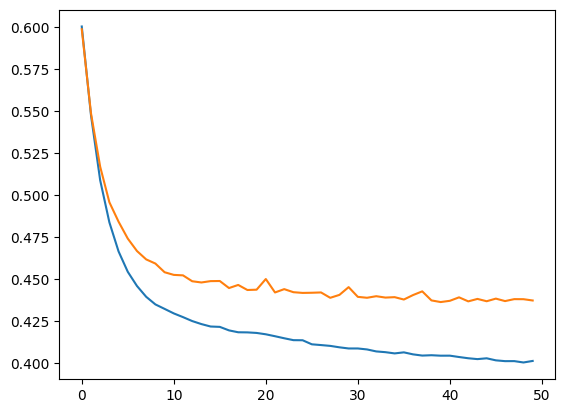

In [21]:
%%time
log = fit_model(50, history)
plt.plot(history['epoch_train_losses'])
plt.plot(history['epoch_valid_losses'])

### Задание 1


Создай файл `recommend.py` в папке `aux` и реализуй в нем 2 функции:
   
__recommend_for_user_id_from_valid__

Функция принимает на вход идентификатор пользователя, делает по нему выборку из валидационной части,
затем прогнозирует рейтинги для тех фильмов, которым пользователь поставил оценку.
Результат работы функции – датафрейм:

| movie_id | title | pred_rating | true_rating |
|----------|-------|-------------|-------------|


_doc-string для функции_

```
Returns dataframe top n movies, true and pred ratings

    Args:
        user_id (int): user_id for predictions
        valid_df (pd.DataFrame): valid dataframe
        model (torch.nn.Module): neural net
        n (int, optional): top_n movies will be returned. Defaults to 10..

    Returns:
        pd.DataFrame: with 4 cols: movie_id, title, pred_rating, true_rating
        shape(n, 4)
       
```



In [22]:
def recommend_for_user_id_from_valid(user_id, valid_df, model, n):
    user_valid_df = valid_df[valid_df['user_id'] == user_id]
    user_valid_dataset = MovieLensDataset(user_valid_df)
    user_valid_loader = DataLoader(user_valid_dataset, batch_size=1, shuffle=False)

    predictions = []
    for user, item, rating in user_valid_loader:
        preds = model(user, item)
        movie_id = item.item()
        title = id_to_movie.get(movie_id, 'title')
        pred_rating = preds.item()
        true_rating = rating.item()
        predictions.append((movie_id, title, pred_rating, true_rating))

    recommendations_df = pd.DataFrame(predictions, columns=['movie_id', 'title', 'pred_rating', 'true_rating'])
    recommendations_df = recommendations_df.nlargest(n, 'pred_rating')

    return recommendations_df

In [23]:
recs = recommend_for_user_id_from_valid(100, valid_df, model, 15)
recs

,movie_id,title,pred_rating,true_rating
6,313,Titanic (1997),4.301519,5.0
5,302,L.A. Confidential (1997),4.281675,4.0
7,316,As Good As It Gets (1997),4.233604,5.0
19,750,Amistad (1997),3.963905,4.0
1,268,Chasing Amy (1997),3.737056,3.0
13,344,"Apostle, The (1997)",3.659565,4.0
11,340,Boogie Nights (1997),3.613646,3.0
4,292,Rosewood (1997),3.578210,2.0
10,333,"Game, The (1997)",3.273378,3.0
18,691,Dark City (1998),3.176103,4.0



__recommend_for_user_id_unwatched__

_doc-string для функции_

```
Return DataFrame with sorted by pred_rating among unwatched films

    Args:
        user_id (int): user_id for recommedations
        full_df (pd.DataFrame): full dataframe
        id_to_movie (dict): dict with id and corresponding movie title

    Returns:
        pd.DataFrame: shape (n_unwatched_movies, 2) with predicted rating and movie title
```

In [24]:
def recommend_for_user_id_unwatched(user_id, full_df, id_to_movie):
    user_full_df = full_df[full_df['user_id'] == user_id]
    user_watched_movies = set(user_full_df['item_id'].values)

    unwatched_movies = full_df[~full_df['item_id'].isin(user_watched_movies)]
    unwatched_movies_dataset = MovieLensDataset(unwatched_movies)
    unwatched_movies_loader = DataLoader(unwatched_movies_dataset, batch_size=1, shuffle=False)

    predictions = []
    for user, item, _ in unwatched_movies_loader:
        preds = model(user, item)
        movie_id = item.item()
        title = id_to_movie.get(movie_id, 'title')
        pred_rating = preds.item()

        predictions.append((movie_id, title, pred_rating))

    recommendations_df = pd.DataFrame(predictions, columns=['movie_id', 'title', 'pred_rating'])
    recommendations_df = recommendations_df.sort_values(by='pred_rating', ascending=False)

    return recommendations_df

In [25]:
recommend_for_user_id_unwatched(100, pd.concat([train_df, valid_df], axis=0),  id_to_movie).head(15)

,movie_id,title,pred_rating
72743,127,"Godfather, The (1972)",4.846709
36236,318,Schindler's List (1993),4.844265
10960,603,Rear Window (1954),4.844133
6195,513,"Third Man, The (1949)",4.843332
61334,318,Schindler's List (1993),4.840050
82408,64,"Shawshank Redemption, The (1994)",4.839950
6200,603,Rear Window (1954),4.839883
34659,50,Star Wars (1977),4.838040
41848,408,"Close Shave, A (1995)",4.835354
70009,483,Casablanca (1942),4.835211


Сохрани файл на `github`

### Задание 2

Реализуй функции для вычисления метрики **precision@k** и **recall@k**.
https://medium.com/@m_n_malaeb/recall-and-precision-at-k-for-recommender-systems-618483226c54

In [34]:
def precision_k(actual_ratings: list, pred_ratings: list, k: int) -> float:
    if k > len(pred_ratings):
        k = len(pred_ratings)
    relevant_items = sum(1 for x in actual_ratings[:k] if x >= 3.5)
    precision = relevant_items / k if k != 0 else 0
    return precision


def recall_k(actual_ratings: list, pred_ratings: list, k: int) -> float:
    if k > len(pred_ratings):
        k = len(pred_ratings)
    actual_relevant = sum(1 for x in actual_ratings if x >= 3.5)
    predicted_relevant = sum(1 for x in actual_ratings[:k] if x >= 3.5)
    recall = predicted_relevant / actual_relevant if actual_relevant != 0 else 0
    return recall

In [35]:
print(precision_k(recs['true_rating'], recs['pred_rating'], k=3), recall_k(recs['true_rating'], recs['pred_rating'], k=3))

1.0 0.42857142857142855


### Задание 3

Создай модель `ModifiedRecNet`, чтобы добиться результатов лучше, чем в `BaseRecNet`. Функция потерь - `RMSE`. Сравни первую и вторую модель по метрикам **precision@k** и **recall@k** на валидационной части выборки.

In [36]:
class ModifiedRecNet(nn.Module):
    def __init__(self, config):
        super().__init__()
        # параметры сети
        self.config = config
        self.num_users = config['num_users']
        self.num_items = config['num_items']
        self.emb_size = config['emb_size']
        self.emb_droupout = config['emb_drop']
        self.dropout = config['lin_drop']
        self.out_range = config['out_range']

        # embedding-слои
        self.emb_user = nn.Sequential(
            nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.emb_size),
            nn.Dropout(p=self.emb_droupout))
        self.emb_item = nn.Sequential(
            nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.emb_size),
            nn.Dropout(p=self.emb_droupout))

        self.lin_user = nn.Linear(self.emb_size, self.emb_size)
        self.lin_item = nn.Linear(self.emb_size, self.emb_size)

        # финальный полносвязный слой для пронгоза оценки
        self.head = nn.Sequential(
            nn.Linear(self.emb_size*2, 512),
            nn.Dropout(self.dropout),
            nn.ReLU(),
            nn.Linear(512, 1)
        )

    def forward(self, user_idx, item_idx):
        user_emb = F.sigmoid(self.lin_user(self.emb_user(user_idx)))
        item_emb = F.sigmoid(self.lin_item(self.emb_item(item_idx)))
        x = torch.cat([user_emb, item_emb], dim=1)
        x = torch.sigmoid(self.head(x)) # [0, 1]
        x = x * (self.out_range[1] - self.out_range[0]) + self.out_range[0]
        return(x)

config = {
    'num_users' : UNIQUE_USERS,  # число уникальных пользователей
    'num_items' : UNIQUE_MOVIES, # число уникальных филмьов
    'emb_size'  : 16,             # размер эмбеддинга
    'emb_drop'  : 0.05,          # параметр для слоя эмбеддинга
    'lin_drop'  : .5,            # dropout
}

### Задание 4


В папке `aux/ml-100k` есть дополнительная информация. Подумай, как можно использовать профессию пользователя, чтобы учитывать еще больше контекста для рекомендаций. Реализуй модель, которая на вход получает эту информацию, обучи ее и сравни результаты.

In [41]:
from sklearn.preprocessing import LabelEncoder

In [42]:
u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv(
    '/content/ml-100k/u.user',
    sep='|', names=u_cols,
    encoding='latin-1',
    parse_dates=True,
    header=None)
users.replace({'M' : 0, 'F': 1}, inplace=True)
users['age'] = (users['age'] - users['age'].mean())/users['age'].std()
users['occupation'] = LabelEncoder().fit_transform(users['occupation'])

In [43]:
ext_train_df = train_df.merge(users, on='user_id', how='left')
ext_valid_df = valid_df.merge(users, on='user_id', how='left')

In [44]:
ext_train_df.head(10)

,user_id,item_id,rating,timestamp,age,sex,occupation,zip_code
0,1,1,5,874965758,-0.824422,0,19,85711
1,1,2,3,876893171,-0.824422,0,19,85711
2,1,3,4,878542960,-0.824422,0,19,85711
3,1,4,3,876893119,-0.824422,0,19,85711
4,1,5,3,889751712,-0.824422,0,19,85711
5,1,7,4,875071561,-0.824422,0,19,85711
6,1,8,1,875072484,-0.824422,0,19,85711
7,1,9,5,878543541,-0.824422,0,19,85711
8,1,11,2,875072262,-0.824422,0,19,85711
9,1,13,5,875071805,-0.824422,0,19,85711


In [45]:
class ExtendedMovieLensDataset(Dataset):
    def __init__(
            self,
            df : pd.DataFrame,
            user_col : int = 0,
            item_col : int = 1,
            rating_col: int = 2,
            age_col : int = 4,
            sex_col : int = 5,
            occ_col : int = 6
            ):

        self.df = df
        self.user_tensor = torch.tensor(self.df.iloc[:,user_col],
                                        dtype=torch.long,
                                        device=device)
        self.item_tensor = torch.tensor(self.df.iloc[:,item_col],
                                        dtype=torch.long,
                                        device = device)
        self.trgt_tensor = torch.tensor(self.df.iloc[:,rating_col],
                                        dtype=torch.float32,
                                        device = device)
        self.age_tensor = torch.tensor(self.df.iloc[:, age_col],
                                        dtype=torch.float16,
                                        device=device)
        self.sex_tensor = torch.tensor(self.df.iloc[:, sex_col],
                                            dtype=torch.long,
                                            device=device)
        self.occ_tensor = torch.tensor(self.df.iloc[:, occ_col],
                                        dtype=torch.long,
                                        device=device)
    def __len__(self):
        return(self.user_tensor.shape[0])

    def __getitem__(self, index):
        return (
            self.user_tensor[index],
            self.item_tensor[index],
            self.age_tensor[index],
            self.sex_tensor[index],
            self.occ_tensor[index],
            self.trgt_tensor[index]
            )

In [46]:
class ExtendedRecNet(nn.Module):
    def __init__(self, config):
        super().__init__()
        # параметры сети
        self.config = config
        self.num_users = config['num_users']
        self.num_items = config['num_items']
        self.emb_size = config['emb_size']
        self.emb_droupout = config['emb_drop']
        self.dropout = config['lin_drop']
        self.out_range = config['out_range']
        self.num_occ = config['num_occ']
        self.occ_emb_size = config['occ_esize']

        # embedding-слои
        self.emb_user = nn.Sequential(
            nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.emb_size),
            nn.Dropout(p=self.emb_droupout))
        self.emb_item = nn.Sequential(
            nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.emb_size),
            nn.Dropout(p=self.emb_droupout))
        self.emb_occ = nn.Embedding(self.num_occ, self.occ_emb_size)


        self.lin_user = nn.Linear(self.emb_size, self.emb_size)
        self.lin_item = nn.Linear(self.emb_size, self.emb_size)
        self.lin_occ = nn.Linear(self.occ_emb_size, self.occ_emb_size)

        # финальный полносвязный слой для пронгоза оценки
        self.head = nn.Sequential(
            # embeddings from user&item (*2) + emb size for job + 1 for age + 1 for sex
            nn.Linear(self.emb_size*2+self.occ_emb_size + 1 + 1, 512),
            nn.Dropout(self.dropout),
            nn.ReLU(),
            nn.Linear(512, 1)
        )



    def forward(self, user_idx, item_idx, age, sex, occ):
        user_emb = F.sigmoid(self.lin_user(self.emb_user(user_idx)))
        item_emb = F.sigmoid(self.lin_item(self.emb_item(item_idx)))
        occ_emb = F.sigmoid(self.lin_occ(self.emb_occ(occ)))
        x = torch.cat(
            [
                user_emb, item_emb, occ_emb,
                age.unsqueeze(1),
                sex.unsqueeze(1)
            ],
            dim=1)
        x = torch.sigmoid(self.head(x)) # [0, 1]
        x = x * (self.out_range[1] - self.out_range[0]) + self.out_range[0]
        return (x)